In [86]:
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Set the starting date for the simulation
start_year = 2024
start_month = 5

# Define the start date as a datetime object
start_date = datetime.date(start_year, start_month, 1)

# Current date information
current_date = datetime.date.today()
current_year = current_date.year
current_month = current_date.month

# Function to calculate month offset from start date
def calculate_month_offset(event_year, event_month):
    return (event_year - start_year) * 12 + (event_month - start_month)

def flip(p):
    return 'yes' if np.random.random() < p else 'no'

# Simulation setup

## Categories of cash flow:
Classify your expenses according to

* Stable: constant sources of income or expense (bills, personnel)
* Singles: single instance source of revenue in a given time (month) with a given chance. Similar to an individual sale or purchase
* Recurrent: if source is realized, it lasts for a given amount of time with recurrent payments in a given frequency
* Project: if source is realized, payments are tied to milestones in time, and with a finite chance of success (failure at meeting milestone may result in either a delay on payment or a full termination of contract)

Investing, operating, or financing events may fall in any of these categories. 

## Data setup

### Single events data

Single events can include grants and awards, large sales or purchases, or any notable event for gain or expense in the organization

In [87]:
# Modify the parameters to include specific dates
singles_params = [
    {'name': 'kick_start', 'chance': 1.0, 'date': datetime.date(2024, 5, 1), 'amount': 2000000},
    {'name': 'major_purchase', 'chance': 1.0, 'date': datetime.date(2024, 5, 1), 'amount': -100000},
    {'name': 'grant_test', 'chance': 0.8, 'date': datetime.date(2024, 9, 1), 'amount': 1000000},
    {'name': 'big_sale', 'chance': 0.5, 'date': datetime.date(2025, 4, 1), 'amount': 500000},
]

### Recurrent events data

Recurrent events indicate cash-flow opportunities that, once awarded, return contributions to revenue or expenses at a given frequency. Examples include scholarships, some grants, some projects, long-term deals for services, etc.

In [88]:
recurrent_params = [
    {'name': 'pappalardo_test', 'chance': 1.0, 'date': datetime.date(2024, 7, 1), 'amount': 1000000, 'duration': 48, 'number': 3, 'payment_frequency': 3},
    {'name': 'another_pappalardo', 'chance': 0.5, 'date': datetime.date(2025, 4, 1), 'amount': 500000, 'duration': 12, 'number': 12},
]

### Stable events data

Stable sources of cash flow out of an organization can include bills and salaries. Flow in can include payments for services, licensed IP or software, sales for stable markets, etc.

In [89]:
stable_sources = [
   {'name': 'Personnel', 'avg_value': 800000, 'std_value': 200000, 'type': 'expense'},
   {'name': 'Utilities', 'avg_value': 200000, 'std_value': 50000, 'type': 'expense'},
  {'name': 'IP_license', 'avg_value': 700000, 'std_value': 200000, 'type': 'income'},
]


### Projects data

Project-based incomes or expenses correspond to events which have payments triggered by successful deliveries of milestones. Examples include most grants.

In [90]:
projects = [
    {
        'name': 'Project A',
        'start_chance': 1.0,
        'kill_chance': 0.1,
        'start_date': datetime.date(2024, 9, 1),
        'milestones': [
            {'name': 'milestone_1', 'date': datetime.date(2024, 9, 1), 'amount': 700000, 'success_chance': 0.9},
            {'name': 'milestone_2', 'date': datetime.date(2025, 2, 1), 'amount': 1500000, 'success_chance': 0.8},
            {'name': 'milestone_3', 'date': datetime.date(2025, 5, 1), 'amount': 2000000, 'success_chance': 0.6},
        ]
    },
    {
        'name': 'Project B',
        'start_chance': 0.8,
        'kill_chance': 0.0,
        'start_date': datetime.date(2024, 11, 1),
        'milestones': [
            {'name': 'milestone_1', 'date': datetime.date(2024, 12, 1), 'amount': 520000, 'success_chance': 0.7},
            {'name': 'milestone_2', 'date': datetime.date(2025, 4, 1), 'amount': 980000, 'success_chance': 0.6},
        ]
    }
]


# Category simulation functions

In [91]:
# Function for single instance cash-flow events
def simulate_single_contribution(num_simulations, num_months, event_params):
    """
    Simulate single contributions based on specified parameters.

    Args:
        num_simulations (int): Number of simulations to run.
        num_months (int): Number of months in the simulation.
        single_params (list of dicts): List of single contribution parameters.
            Each dict contains:
                - 'name': Name of the single cash event.
                - 'chance': Probability of obtaining the event.
                - 'month': Month in which the event would be awarded.
                - 'amount': Amount of cash in the event.

    Returns:
        dict: Dictionary containing single cash event contributions as numpy arrays.
            Keys are event names, and values are numpy arrays of size
            (num_simulations, num_months) representing event contributions.
    """
    event_contribution = {}

    for event in event_params:
        name = event['name']
        chance_getting = event['chance']
        month_getting = calculate_month_offset(event['date'].year, event['date'].month)
        amount = event['amount']

        event_contribution[name] = np.zeros((num_simulations, num_months))

        if 0 <= month_getting < num_months:
            for sim in range(num_simulations):
                if flip(chance_getting) == 'yes':
                    event_contribution[name][sim][month_getting] = amount

    return event_contribution


In [92]:
# Function for recurrent cash-flow events
def simulate_recurrent_contribution(num_simulations, num_months, event_params):
    """
    Simulate recurrent contributions based on specified parameters.

    Args:
        num_simulations (int): Number of simulations to run.
        num_months (int): Number of months in the simulation.
        recurrent_params (list of dicts): List of recurrent event parameters.
            Each dict contains:
                - 'name': Name of the event.
                - 'chance': Probability of obtaining the event.
                - 'month': Month in which the event would be awarded.
                - 'amount': Total amount of the event award.
                - 'duration': How many months the event lasts
                - 'number': number of events of this type
                - 'payment_frequency': Frequency of award payments (e.g., 1 for monthly, 3 for quarterly).


    Returns:
        dict: Dictionary containing event contributions as numpy arrays.
            Keys are event names, and values are numpy arrays of size
            (num_simulations, num_months) representing scholarship contributions.
    """
    event_contribution = {}
        
    for event in event_params:
        name = event['name']
        chance_getting = event['chance']
        month_getting = calculate_month_offset(event['date'].year, event['date'].month)
        amount = event['amount']
        duration = event['duration']
        number = event['number']
        payment_frequency = event.get('payment_frequency', 1)

        event_contribution[name] = np.zeros((num_simulations, num_months))

        if 0 <= month_getting < num_months:
            for sim in range(num_simulations):
                total_awards = sum([1 for _ in range(number) if flip(chance_getting) == 'yes'])

                end_month = min(duration + month_getting, num_months)
                for month in range(month_getting, end_month):
                    if (month - month_getting) % payment_frequency == 0:
                        # Calculate payment amount based on payment frequency
                        payment_amount = amount / (12 / payment_frequency) * total_awards
                        event_contribution[name][sim][month] = payment_amount

    return event_contribution

In [93]:
# Function for continuous stable flow
def simulate_stable_expenses(num_simulations, num_months, event_params):
    """
    Simulate stable expenses based on specified parameters for multiple expense sources.

    Args:
        num_simulations (int): Number of simulations to run.
        num_months (int): Number of months in the simulation.
        expense_sources (list of dicts): List of dictionaries containing parameters for expense sources.
            Each dictionary contains:
                - 'name': Name of the expense source.
                - 'avg_value': Average monthly value for the expense source.
                - 'std_value': Standard deviation corresponding to the expense source.
                - 'type': Type of cash flow ('income' or 'expense').

    Returns:
        dict: Dictionary containing simulated expense contributions for all expense sources.
            Keys are expense names, and values are numpy arrays of size
            (num_simulations, num_months) representing expense contributions.
    """
    event_contribution = {}

    for event in event_params:
        name = event['name']
        avg_value = event['avg_value']
        std_value = event['std_value']
        source_type = event['type']

        # Calculate the parameters for the log-normal distribution
        mu = np.log(avg_value**2 / np.sqrt(std_value**2 + avg_value**2))
        sigma = np.sqrt(np.log(1 + (std_value**2 / avg_value**2)))

        event_contribution[name] = np.zeros((num_simulations, num_months))

        for sim in range(num_simulations):
            # Generate monthly expenses using log-normal distribution
            monthly_values = np.random.lognormal(mean=mu, sigma=sigma, size=num_months)

        # Adjust values based on source type (income or expense)
            if source_type == 'expense':
                monthly_values = -monthly_values
            
            event_contribution[name][sim] = monthly_values

    return event_contribution

In [94]:
# Function for milestone-based flows
def simulate_project_cash_flows(num_simulations, num_months, projects):
    """
    Simulate cash flows for multiple projects based on specified parameters.

    Args:
        num_simulations (int): Number of simulations to run.
        num_months (int): Number of months in the simulation.
        projects (list of dicts): List of dictionaries containing project parameters.

    Returns:
        dict: Dictionary containing simulated cash flow contributions for all projects.
            Keys are milestone names, and values are numpy arrays of size
            (num_simulations, num_months) representing cash flow contributions.
    """
    all_cash_flows = {}

    for project_params in projects:
        project_name = project_params.get('name', 'Project')
        start_chance = project_params.get('start_chance', 1.0)
        kill_chance = project_params.get('kill_chance', 0.0)
        project_start_date = project_params.get('start_date')
        start_offset = calculate_month_offset(project_start_date.year, project_start_date.month)
        milestones = project_params.get('milestones', [])

        cash_flow = {}

        for milestone in milestones:
            milestone_name = milestone['name']
            milestone_date = milestone['date']
            milestone_amount = milestone['amount']
            success_chance = milestone['success_chance']
            milestone_offset = calculate_month_offset(milestone_date.year, milestone_date.month)

            cash_flow[milestone_name] = np.zeros((num_simulations, num_months))

            for sim in range(num_simulations):
                project_status = flip(start_chance)
                if project_status == 'yes':
                    for month in range(start_offset, num_months):
                        if month == milestone_offset:
                            milestone_status = flip(success_chance)
                            if milestone_status == 'yes':
                                cash_flow[milestone_name][sim][month] += milestone_amount
                                break  # Record cash flow for successful milestone
                            else:
                                # Adjust the subsequent milestones if the current one fails
                                for subsequent_milestone in milestones:
                                    subsequent_milestone_offset = calculate_month_offset(
                                        subsequent_milestone['date'].year,
                                        subsequent_milestone['date'].month
                                    )
                                    if subsequent_milestone_offset > milestone_offset:
                                        subsequent_milestone_offset += 1
                                        if flip(kill_chance) == 'yes':
                                            break
                                if flip(kill_chance) == 'yes':
                                    break
                        elif flip(kill_chance) == 'yes':
                            break
                else:
                    break

        all_cash_flows[project_name] = cash_flow

    return all_cash_flows


# Running simulations

In [95]:
# Number of simulations and months to consider
num_simulations = 1000
num_forecast_months = 24
num_past_months = calculate_month_offset(current_year, current_month)


# Total number of months for the simulation
num_months = num_forecast_months + num_past_months

singles_results = np.zeros((num_simulations, num_forecast_months))
recurrent_results = np.zeros((num_simulations, num_forecast_months))
stable_results = np.zeros((num_simulations, num_forecast_months))
project_results = np.zeros((num_simulations, num_forecast_months))

# Simulate single source contributions
singles_results = simulate_single_contribution(num_simulations, num_months, singles_params)

# Simulate recurrent contributions
recurrent_results = simulate_recurrent_contribution(num_simulations, num_months, recurrent_params)

# Simulate stable expenses for multiple expense sources
stable_results = simulate_stable_expenses(num_simulations, num_months, stable_sources)

# Simulate cash flows for multiple projects
project_results = simulate_project_cash_flows(num_simulations, num_months, projects)

# Data analysis

In [96]:
# Calculate revenue and expenses, and cashflow for each simulation and month
total_singles = np.sum(list(singles_results.values()), axis=0) if isinstance(singles_results, dict) else singles_results
singles_revenue= np.sum([value * (value > 0) for value in singles_results.values()],axis=0)
singles_expenses= np.sum([value * (value < 0) for value in singles_results.values()],axis=0)


total_recurrent = np.sum(list(recurrent_results.values()), axis=0) if isinstance(recurrent_results, dict) else recurrent_results
recurrent_revenue= np.sum([value * (value > 0) for value in recurrent_results.values()],axis=0)
recurrent_expenses= np.sum([value * (value < 0) for value in recurrent_results.values()],axis=0)


total_stable = np.sum(list(stable_results.values()), axis=0) if isinstance(stable_results, dict) else stable_results
stable_revenue= np.sum([value * (value > 0) for value in stable_results.values()],axis=0)
stable_expenses= np.sum([value * (value < 0) for value in stable_results.values()],axis=0)


total_projects = np.zeros((num_simulations, num_months))
projects_revenue = np.zeros((num_simulations, num_months))
projects_expenses = np.zeros((num_simulations, num_months))

# Check if project_results is a dictionary, then perform the calculations
if isinstance(project_results, dict):
    for project_cash_flow in project_results.values():
        for cash_flow_array in project_cash_flow.values():
            # Accumulate total, positive, and negative cash flows
            total_projects += cash_flow_array
            projects_revenue += cash_flow_array * (cash_flow_array > 0)
            projects_expenses += cash_flow_array * (cash_flow_array < 0)
else:
    # If project_results is not a dictionary, assign directly
    total_projects = project_results
    projects_revenue = project_results * (project_results > 0)
    projects_expenses = project_results * (project_results < 0)



# Calculate monthly cash flow for each simulation
monthly_cash_flow = total_singles + total_recurrent + total_stable + total_projects
monthly_revenue = singles_revenue + recurrent_revenue + stable_revenue + projects_revenue
monthly_expenses = singles_expenses + recurrent_expenses + stable_expenses + projects_expenses

# Calculate total accumulated funds over time for each simulation
accumulated_funds = np.cumsum(monthly_cash_flow, axis=1)

# Adjust to show only forecast period (starting from the current date)
monthly_cash_flow_forecast = monthly_cash_flow[:, num_past_months:]
monthly_revenue_forecast = monthly_revenue[:, num_past_months:]
monthly_expense_forecast = monthly_expenses[:, num_past_months:]

accumulated_funds_forecast = accumulated_funds[:, num_past_months:]

# Calculate statistics over all simulations for each month
mean_cash_flow = np.mean(monthly_cash_flow_forecast, axis=0)
std_dev_cash_flow = np.std(monthly_cash_flow_forecast, axis=0)

# Calculate the probability of going negative in each month
probability_negative_balance = np.mean(accumulated_funds_forecast < 0, axis=0) * 100
max_prob = np.max(probability_negative_balance)



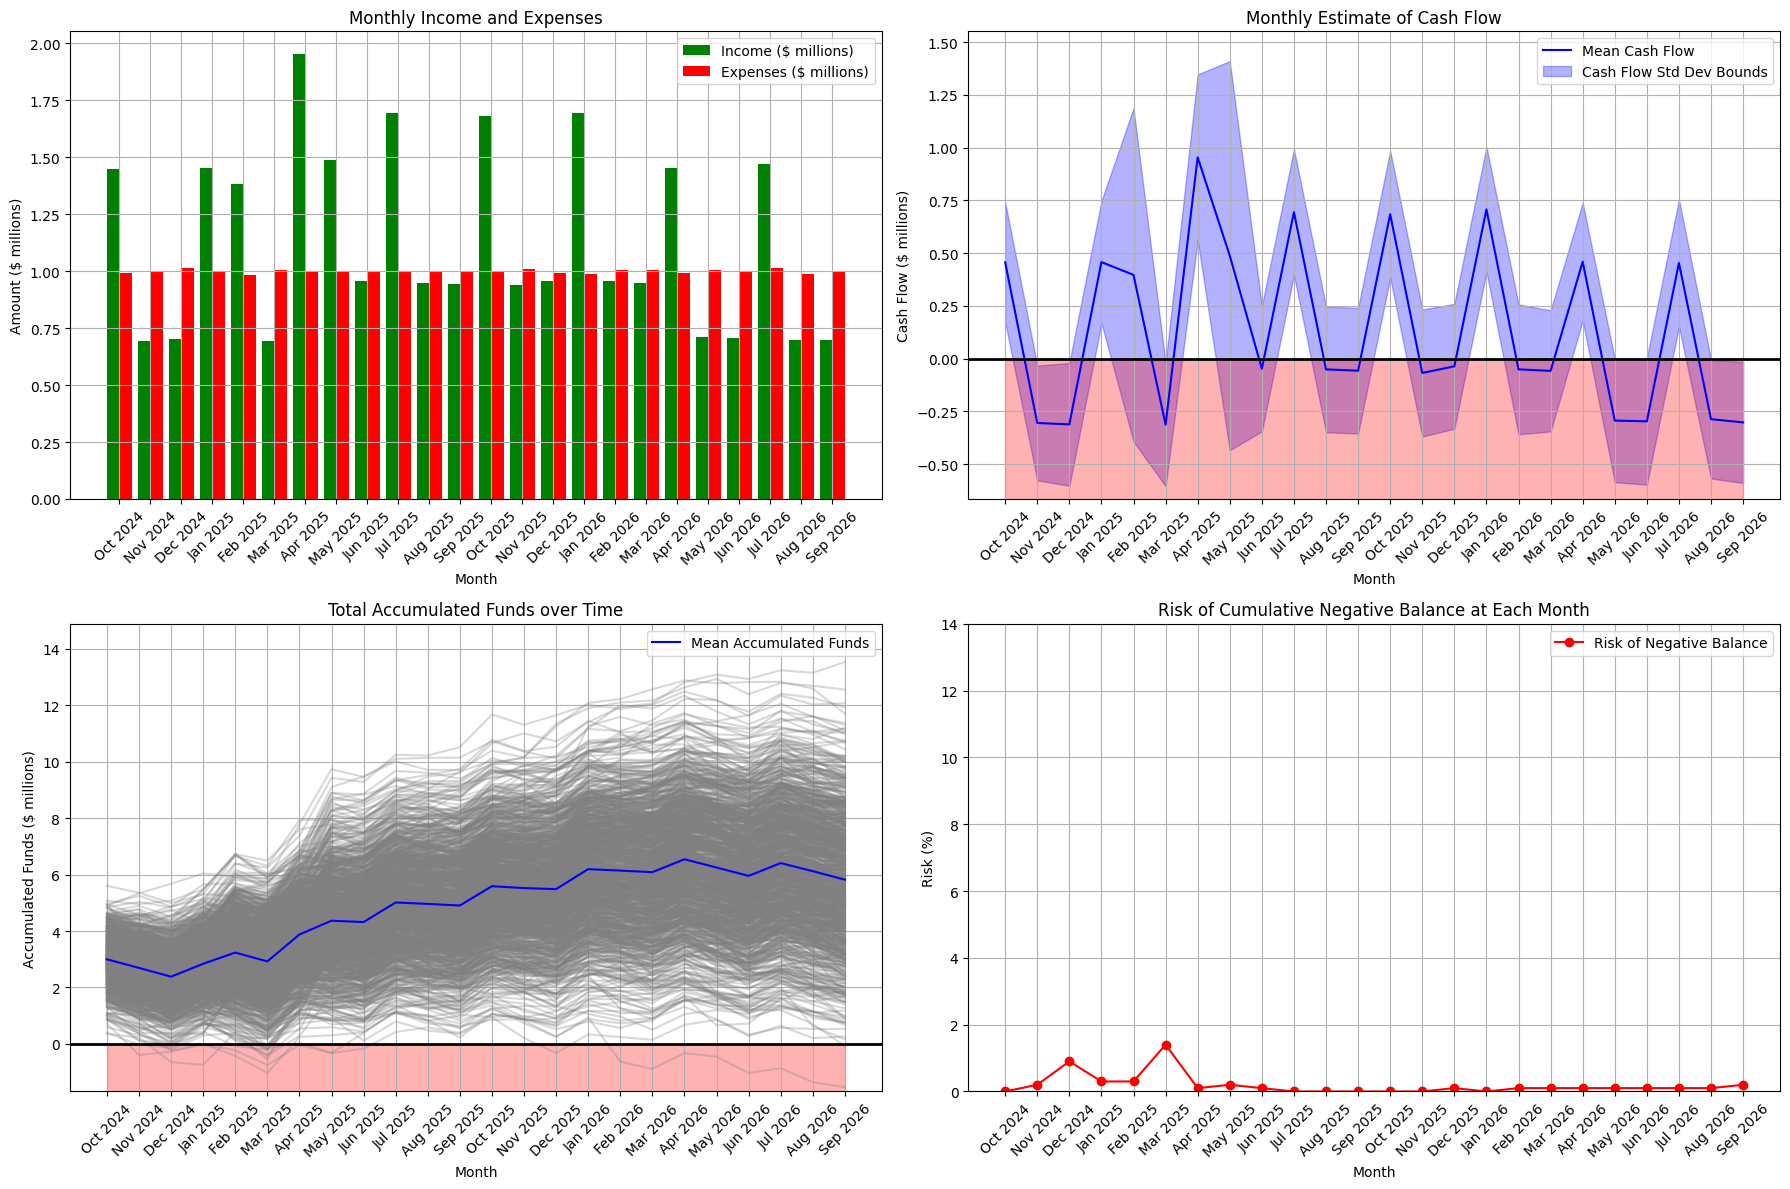

In [97]:
# Calculate the end date for the forecast period
end_year = current_year + (current_month + num_forecast_months - 1) // 12
end_month = (current_month + num_forecast_months - 1) % 12 + 1


# Create the range of months for plotting
months = np.arange(1, num_forecast_months + 1)
month_labels = []
for i in range(num_forecast_months):
    year = current_year + (current_month + i - 1) // 12
    month = (current_month + i - 1) % 12 + 1
    month_labels.append(f'{datetime.datetime(year, month, 1).strftime("%b %Y")}')

def plot_monthly_histogram(monthly_revenue_forecast,monthly_expense_forecast, num_forecast_months):
    income_histogram = np.zeros(num_forecast_months)
    expense_histogram = np.zeros(num_forecast_months)

    # Calculate income and expenses for each month in the forecast period
    for month in range(num_forecast_months):
        income_histogram[month] = np.sum(monthly_revenue_forecast[:, month])/ num_simulations
        expense_histogram[month] = np.sum(np.abs(monthly_expense_forecast[:, month]))/ num_simulations

    # Plot the histogram
    plt.bar(months - 0.2, income_histogram / 1e6, width=0.4, label='Income ($ millions)', color='green')
    plt.bar(months + 0.2, expense_histogram / 1e6, width=0.4, label='Expenses ($ millions)', color='red')

    plt.title('Monthly Income and Expenses')
    plt.xlabel('Month')
    plt.ylabel('Amount ($ millions)')
    plt.xticks(months, month_labels, rotation=45)
    plt.legend()
    plt.grid(True)

plt.figure(figsize=(18, 12))

# Plot the monthly histogram of income and expenses
plt.subplot(2, 2, 1)
plot_monthly_histogram(monthly_revenue_forecast,monthly_expense_forecast, num_forecast_months)

# Plot the monthly estimate of total cash flow (mean with std dev bounds)
max_val = np.max((mean_cash_flow + std_dev_cash_flow) / 1e6)
min_val = np.min((mean_cash_flow - std_dev_cash_flow) / 1e6)

plt.subplot(2, 2, 2)
plt.plot(months, mean_cash_flow / 1e6, label='Mean Cash Flow', color='b')
plt.fill_between(months, (mean_cash_flow - std_dev_cash_flow) / 1e6, 
                 (mean_cash_flow + std_dev_cash_flow) / 1e6,
                 alpha=0.3, color='b', label='Cash Flow Std Dev Bounds')
plt.axhline(0, color='black', linewidth=2)  # Add a thick black line at y=0
plt.fill_between(months, -1.1 * max_val, 0, color='red', alpha=0.3)  # Fill the negative y-plane with red
plt.title('Monthly Estimate of Cash Flow')
plt.xlabel('Month')
plt.ylabel('Cash Flow ($ millions)')
plt.legend()
plt.grid(True)
plt.ylim(1.1 * min_val, 1.1 * max_val)
plt.xticks(months, month_labels, rotation=45)

# Plot the total accumulated funds over time
max_tot_val = np.max(accumulated_funds_forecast / 1e6)
min_tot_val = np.min(accumulated_funds_forecast / 1e6)

plt.subplot(2, 2, 3)
for sim in range(num_simulations):
    plt.plot(months, accumulated_funds_forecast[sim] / 1e6, alpha=0.3, color='gray')  # Plot each simulation
plt.plot(months, np.mean(accumulated_funds_forecast, axis=0) / 1e6, label='Mean Accumulated Funds', color='b')
plt.axhline(0, color='black', linewidth=2)  # Add a thick black line at y=0
plt.fill_between(months, -np.max(accumulated_funds_forecast) / 1e6, 0, color='red', alpha=0.3)  # Fill the negative y-plane with red
plt.title('Total Accumulated Funds over Time')
plt.xlabel('Month')
plt.ylabel('Accumulated Funds ($ millions)')
plt.legend()
plt.grid(True)
plt.ylim(1.1 * min_tot_val, 1.1 * max_tot_val)
plt.xticks(months, month_labels, rotation=45)

# Plot the risk of going negative
plt.subplot(2, 2, 4)
plt.plot(months, probability_negative_balance, label='Risk of Negative Balance', color='r', marker='o')
plt.title('Risk of Cumulative Negative Balance at Each Month')
plt.xlabel('Month')
plt.ylabel('Risk (%)')
plt.ylim(0, np.min([100, 10 * max_prob]))
plt.legend()
plt.grid(True)
plt.xticks(months, month_labels, rotation=45)

# Adjust layout and display the plots
plt.tight_layout()
plt.savefig('cash_flower_analysis_example.png', dpi=300, bbox_inches='tight')
plt.show()
